# Simplified Custom Object Detection


## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

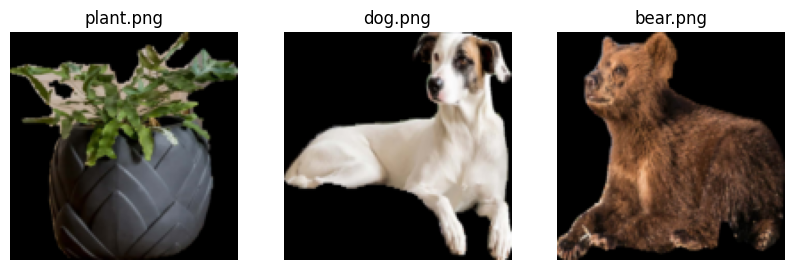

In [ ]:
import os
import cv2
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Filter out hidden files or directories
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f)) and not f.startswith('.')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        # Load the image using OpenCV
        image = cv2.imread(img_path)
        # Convert BGR (OpenCV format) to RGB (matplotlib format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Define transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV image (numpy array) to PIL format
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor()  # Convert to tensor
])

# Create an instance of the dataset
dataset = CustomImageDataset(root_dir='/content/drive/MyDrive/DND/data/objects', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

# Plot the images in a batch
images, img_names = next(iter(dataloader))

# Plot the images and their filenames
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axes[i].imshow(images[i].permute(1, 2, 0))  # Permute for correct channel order
    axes[i].set_title(img_names[i])
    axes[i].axis('off')

plt.show()


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir':  'data/background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto') #, min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

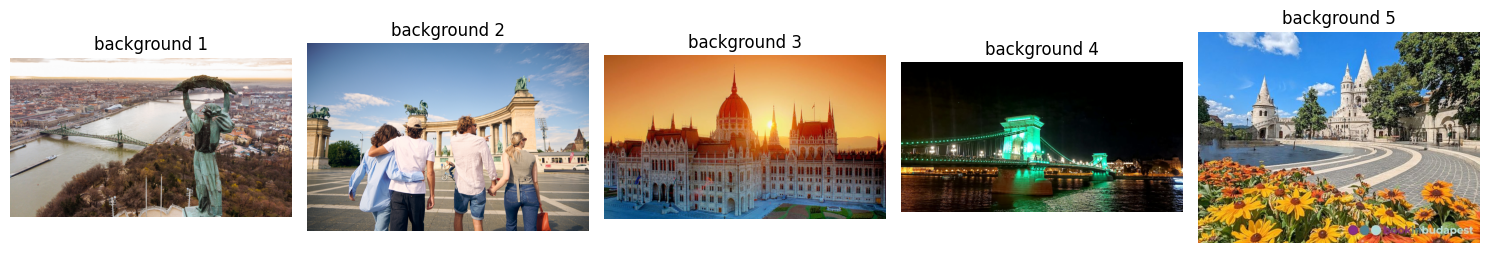

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
directory = '/content/drive/MyDrive/DND/data/background'
def display_sample_images(directory, num_samples=5):
    # Get a list of all image files in the directory
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Randomly select a number of samples
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    # Set up the figure
    plt.figure(figsize=(15, 10))

    for i, image_file in enumerate(sample_files):
        # Read and display each image
        img_path = os.path.join(directory, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.title(f'background {i+1}')  # Show the file name as the title

    plt.tight_layout()
    plt.show()

# display sample images
display_sample_images(directory)


### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [ ]:
import os
import random
import cv2
import numpy as np
from PIL import Image  # Ensure you import PIL

class CustomDataset:
    def __init__(self, root_dir, img_size, num_images):
        self.root_dir = root_dir
        self.img_size = img_size
        self.num_images = num_images
        self.classes = ['bear', 'dog', 'plant']  # object classes
        self.background_images = self.load_background_images()
        self.objects = self.load_objects()
        # Create a mapping for random object sizes
        self.size_map = {object_name: random.randint(100, 150) for object_name in self.classes}  # Random sizes between 100 and 150


    def load_background_images(self):
        # Load background images from a directory
        background_dir = os.path.join(self.root_dir, 'background')
        background_images = []
        try:
            for img in os.listdir(background_dir):
                if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                    background_images.append(os.path.join(background_dir, img))
        except Exception as e:
            print(f"Error loading background images: {e}")
        return background_images

    def load_objects(self):
        # Load object images from a directory
        object_dir = os.path.join(self.root_dir, 'objects')
        object_images = []
        try:
            for obj in os.listdir(object_dir):
                if obj.lower().endswith(('.png', '.jpg', '.jpeg')):
                    object_images.append(os.path.join(object_dir, obj))
        except Exception as e:
            print(f"Error loading object images: {e}")
        return object_images

    def create_bounding_box(self, x, y, w, h, image_width, image_height):
        # Convert to YOLO format
        x_center = (x + w / 2) / image_width
        y_center = (y + h / 2) / image_height
        w_norm = w / image_width
        h_norm = h / image_height
        return [x_center, y_center, w_norm, h_norm]

    def place_object_in_background(self, background_image_path, img_size, object_image_path):
        try:
            # Load the background with transparency (RGBA)
            background = Image.open(background_image_path).convert('RGBA').resize(img_size)

            # Load the object with transparency (RGBA)
            class_name = os.path.splitext(os.path.basename(object_image_path))[0]
            object_size = self.size_map.get(class_name, 100)  # Get random size from size_map, default to 100 if not found
            object_image = Image.open(object_image_path).convert('RGBA').resize((object_size, object_size))

            # Randomly determine position to place the object
            obj_width, obj_height = object_image.size
            image_width, image_height = background.size

            x = random.randint(0, image_width - obj_width)
            y = random.randint(0, image_height - obj_height)

            # Create a bounding box in normalized coordinates
            bounding_box = self.create_bounding_box(x, y, obj_width, obj_height, image_width, image_height)

            # Paste the object into the background using alpha compositing
            background.paste(object_image, (x, y), object_image)  # Alpha channel used for transparency

            # Convert the final image to RGB for training (no alpha channel needed during training)
            final_image = background.convert('RGB')

            return final_image, bounding_box

        except Exception as e:
            print(f"Error placing object in background: {e}")
            return None, None

    def save_dataset(self, split, img_size):
        split_dir = os.path.join(self.root_dir, 'dataset', split)
        images_dir = os.path.join(split_dir, 'images')
        labels_dir = os.path.join(split_dir, 'labels')
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        for i in range(self.num_images):
            try:
                background_image_path = random.choice(self.background_images)
                object_image_path = random.choice(self.objects)
                class_name = os.path.splitext(os.path.basename(object_image_path))[0]
                class_id = self.classes.index(class_name)

                generated_image, bounding_box = self.place_object_in_background(background_image_path, img_size, object_image_path)

                if generated_image is None or bounding_box is None:
                    print(f"Skipping image generation for index {i + 1}: failed to generate image.")
                    continue  # Skip to the next iteration if there's an error

                # Save the image
                image_filename = f'{i + 1:05d}.jpg'
                cv2.imwrite(os.path.join(images_dir, image_filename), cv2.cvtColor(np.array(generated_image), cv2.COLOR_RGB2BGR))

                # Save the label in YOLO format
                label_filename = f'{i + 1:05d}.txt'
                with open(os.path.join(labels_dir, label_filename), 'w') as label_file:
                    label_file.write(f'{class_id} {" ".join(map(str, bounding_box))}\n')

            except Exception as e:
                print(f"Error saving dataset for index {i + 1}: {e}")

def createDataset(root_dir, dataset_name, split, img_size, num_images):
    try:
        dataset = CustomDataset(root_dir, img_size, num_images)
        dataset.save_dataset(split, img_size)
    except Exception as e:
        print(f"Error creating dataset: {e}")

# Create the datasets
createDataset('/content/drive/MyDrive/DND/data', 'background', split='train', img_size=(640, 640), num_images=5000)
createDataset('/content/drive/MyDrive/DND/data', 'background', split='val', img_size=(640, 640), num_images=1000)
createDataset('/content/drive/MyDrive/DND/data', 'background', split='test', img_size=(640, 640), num_images=200)


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")

        # Load corresponding label (bounding box + class)
        label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.txt'))
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # YOLO format for bounding box: class_idx, center_x, center_y, width, height (all normalized)
        boxes = []
        categories = []
        for label in labels:
            class_idx, center_x, center_y, width, height = map(float, label.split())
            categories.append(int(class_idx))
            boxes.append([center_x, center_y, width, height])

        # Take only the first object’s class as a single target for now (to fix the error)
        categories = categories[0]  # Get the first object's class index (as an integer)

        # Convert to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        categories = torch.tensor(categories, dtype=torch.long)

        # Apply transformations to the image if any
        if self.transform:
            image = self.transform(image)

        return image, categories, boxes


In [ ]:
# Data Loaders

root_dir = r'/content/drive/MyDrive/DND/data'
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

# Initialize datasets
train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

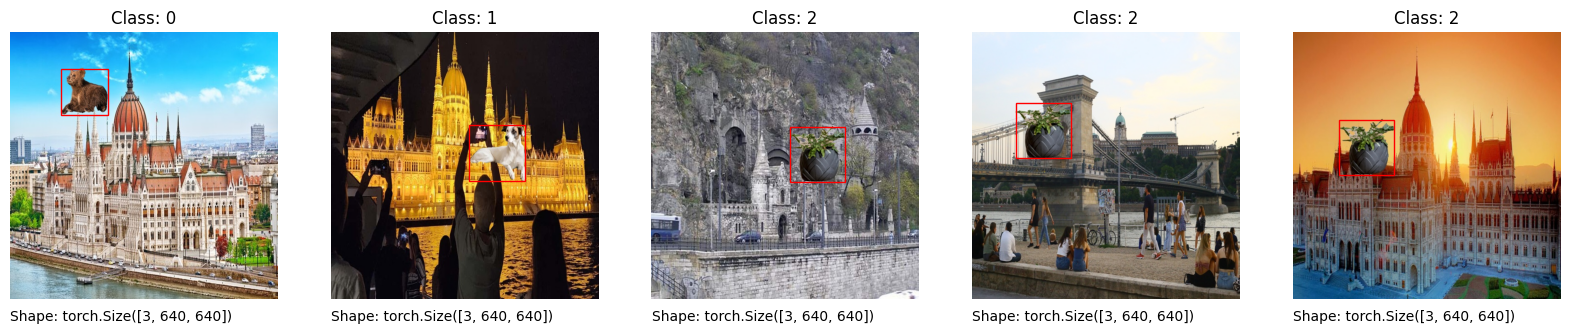

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
# Show some visualizations of the created dataset
def visualize_dataset(dataset, num_sample=5):
    fig, axes = plt.subplots(1, num_sample, figsize=(20, 5))
    random_indices = random.sample(range(len(dataset)), num_sample)
    for i, idx in enumerate(random_indices):
        image, labels, bbox_list = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))

        # Create a rectangle patch for each bounding box
        for bbox_item in bbox_list:
            bbox_x, bbox_y, bbox_w, bbox_h = bbox_item.tolist()
            bbox_x *= image.shape[2]
            bbox_y *= image.shape[1]
            bbox_w *= image.shape[2]
            bbox_h *= image.shape[1]
            rect = patches.Rectangle((bbox_x - bbox_w / 2, bbox_y - bbox_h / 2), bbox_w, bbox_h, linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)

        axes[i].set_title(f'Class: {labels}')
        axes[i].axis('off')  # Turn off axis

        # Display image shape below the image
        axes[i].text(0, image.shape[1] + 50, f'Shape: {image.shape}', fontsize=10, color='black')

    plt.show()

visualize_dataset(train_dataset)

### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# ADD YOUR CODE HERE

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        # Define custom backbone
        # Detection layers

    def forward(self, x):
        pass
        # return class_probs, bbox_regression

In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Block, 3, intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(Block, 4, intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(Block, 6, intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(Block, 3, intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Calculate backbone output size using the last Block instance
        self.backbone_output_size = 512 * Block(0, 0).expansion  # Use a dummy Block instance

        # Detection layers for class probabilities
        self.class_layer = nn.Sequential(
            nn.Linear(self.backbone_output_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

        # Detection layers for bounding box regression
        self.bbox_layer = nn.Sequential(
            nn.Linear(self.backbone_output_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output size is 4 for x, y, width, and height
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)

        # Get class probabilities and bounding box predictions
        class_probs = self.class_layer(x)
        bbox_preds = self.bbox_layer(x)

        return class_probs, bbox_preds

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

In [ ]:
# ADD YOUR CODE HERE
optimizer = None
class_loss_fn = None
bbox_loss_fn = None

def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []
    # ADD YOUR CODE HERE
    pass

def plot_losses(train_losses, val_losses):
    # ADD YOUR CODE HERE
    pass

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10)
plot_losses(train_losses, val_losses)

<ipython-input-8-00e9aa349e0b>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-8-00e9aa349e0b>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([16, 1, 4])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
Epoch 1/10 [Train]: 100%|█████████▉| 312/313 [01:47<00:00,  2.93it/s, total_loss=0.3501, bbox_loss=0.0909, lr=0.000549]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: U


Epoch 1/10:
Training BBox Loss: 0.0784
Validation BBox Loss: 0.0756
Total Val Loss: 0.2749
Learning Rate: 0.000551
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s, val_bbox_loss=0.0905]



Epoch 2/10:
Training BBox Loss: 0.0787
Validation BBox Loss: 0.0752
Total Val Loss: 0.4348
Learning Rate: 0.001000
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s, val_bbox_loss=0.0971]



Epoch 3/10:
Training BBox Loss: 0.0787
Validation BBox Loss: 0.0765
Total Val Loss: 0.3150
Learning Rate: 0.000962
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s, val_bbox_loss=0.0885]



Epoch 4/10:
Training BBox Loss: 0.0787
Validation BBox Loss: 0.0754
Total Val Loss: 0.2753
Learning Rate: 0.000853
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s, val_bbox_loss=0.0863]



Epoch 5/10:
Training BBox Loss: 0.0785
Validation BBox Loss: 0.0756
Total Val Loss: 0.2767
Learning Rate: 0.000691
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s, val_bbox_loss=0.0903]



Epoch 6/10:
Training BBox Loss: 0.0785
Validation BBox Loss: 0.0749
Total Val Loss: 0.2699
Learning Rate: 0.000500
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s, val_bbox_loss=0.0909]



Epoch 7/10:
Training BBox Loss: 0.0784
Validation BBox Loss: 0.0753
Total Val Loss: 0.3113
Learning Rate: 0.000309
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s, val_bbox_loss=0.0912]



Epoch 8/10:
Training BBox Loss: 0.0784
Validation BBox Loss: 0.0755
Total Val Loss: 0.2679
Learning Rate: 0.000147
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s, val_bbox_loss=0.0915]



Epoch 9/10:
Training BBox Loss: 0.0784
Validation BBox Loss: 0.0753
Total Val Loss: 0.2658
Learning Rate: 0.000039
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s, val_bbox_loss=0.0914]



Epoch 10/10:
Training BBox Loss: 0.0783
Validation BBox Loss: 0.0753
Total Val Loss: 0.2658
Learning Rate: 0.000001
--------------------------------------------------


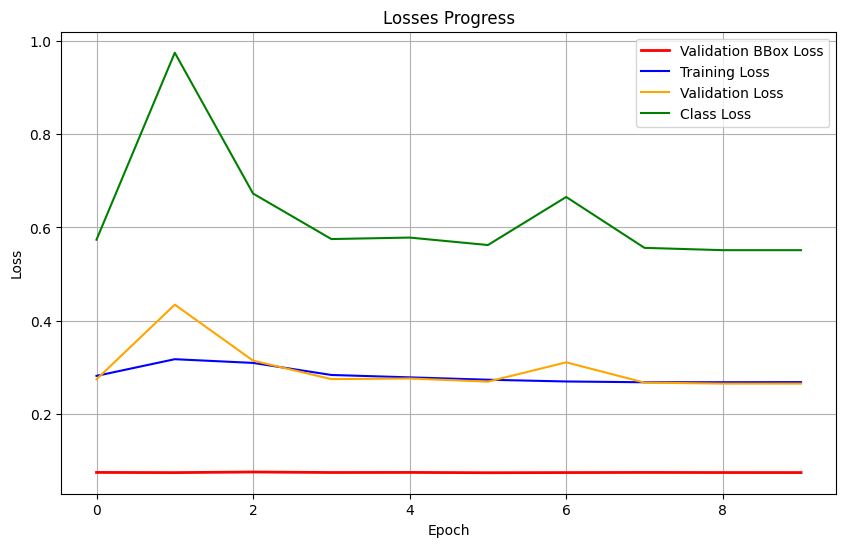

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR  # Correct import
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize loss functions
    class_loss_fn = nn.CrossEntropyLoss()
    bbox_loss_fn = nn.SmoothL1Loss(beta=0.1)

    # Optimizer setup
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.0005
    )

    # Corrected scheduler initialization
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.001,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        div_factor=10.0,
        final_div_factor=100.0
    )

    scaler = GradScaler()

    train_losses = []
    val_losses = []
    val_class_losses = []
    val_box_losses = []
    best_bbox_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_losses = []
        epoch_train_bbox_losses = []

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for images, class_labels, bbox_targets in train_pbar:
            images = images.to(device)
            class_labels = class_labels.to(device)
            bbox_targets = bbox_targets.to(device)

            with autocast():
                class_preds, bbox_preds = model(images)

                class_loss = class_loss_fn(class_preds, class_labels)
                bbox_loss = bbox_loss_fn(bbox_preds, bbox_targets)

                # 80-20 split favoring bbox loss
                total_loss = class_loss * 0.4 + bbox_loss * 0.6

            optimizer.zero_grad()
            scaler.scale(total_loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            epoch_train_losses.append(total_loss.item())
            epoch_train_bbox_losses.append(bbox_loss.item())

            train_pbar.set_postfix({
                'total_loss': f'{total_loss.item():.4f}',
                'bbox_loss': f'{bbox_loss.item():.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

        # Validation phase
        model.eval()
        epoch_val_losses = []
        epoch_val_class_losses = []
        epoch_val_box_losses = []

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for images, class_labels, bbox_targets in val_pbar:
                images = images.to(device)
                class_labels = class_labels.to(device)
                bbox_targets = bbox_targets.to(device)

                class_preds, bbox_preds = model(images)

                class_loss = class_loss_fn(class_preds, class_labels)
                bbox_loss = bbox_loss_fn(bbox_preds, bbox_targets)
                total_loss = class_loss * 0.4 + bbox_loss * 0.6

                epoch_val_losses.append(total_loss.item())
                epoch_val_class_losses.append(class_loss.item())
                epoch_val_box_losses.append(bbox_loss.item())

                val_pbar.set_postfix({
                    'val_bbox_loss': f'{bbox_loss.item():.4f}'
                })

        # Calculate average losses
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        avg_train_bbox_loss = sum(epoch_train_bbox_losses) / len(epoch_train_bbox_losses)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        avg_val_class_loss = sum(epoch_val_class_losses) / len(epoch_val_class_losses)
        avg_val_box_loss = sum(epoch_val_box_losses) / len(epoch_val_box_losses)

        # Save best model based on bbox loss
        if avg_val_box_loss < best_bbox_loss:
            best_bbox_loss = avg_val_box_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'bbox_loss': best_bbox_loss,
            }, 'best_bbox_model.pth')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_class_losses.append(avg_val_class_loss)
        val_box_losses.append(avg_val_box_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training BBox Loss: {avg_train_bbox_loss:.4f}')
        print(f'Validation BBox Loss: {avg_val_box_loss:.4f}')
        print(f'Total Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

    return train_losses, val_losses, val_class_losses, val_box_losses

def plot_losses(train_losses, val_losses, val_class_losses, val_box_losses):
    plt.figure(figsize=(10, 6))

    # Plotting all losses in one plot
    plt.plot(val_box_losses, label='Validation BBox Loss', color='red', linewidth=2)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.plot(val_class_losses, label='Class Loss', color='green')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses Progress')
    plt.legend()
    plt.grid(True)

    plt.show()

# Train the model and plot losses
train_losses, val_losses, val_class_losses, val_box_losses = train_model(model, train_loader, val_loader, num_epochs=10)
plot_losses(train_losses, val_losses, val_class_losses, val_box_losses)


### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [ ]:
def evaluate_test_set(model, test_loader, device):
    model.eval()
    # ADD YOUR CODE
    pass

precision, recall, mAP = evaluate_test_set(model, test_loader, device)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, average_precision_score

def evaluate_test_set(model, test_loader, device):
    model.eval()
    all_gt_boxes = []
    all_pred_boxes = []
    all_gt_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, gt_labels, gt_boxes in test_loader:
            images = images.to(device)
            class_probs, bbox_preds = model(images)
            class_probs = class_probs.cpu().numpy()
            bbox_preds = bbox_preds.cpu().numpy()
            pred_labels = np.argmax(class_probs, axis=1)
            pred_boxes = bbox_preds

            all_gt_boxes.append(gt_boxes)
            all_pred_boxes.append(pred_boxes)
            all_gt_labels.append(gt_labels)
            all_pred_labels.append(pred_labels)

    all_gt_boxes = np.concatenate(all_gt_boxes)
    all_pred_boxes = np.concatenate(all_pred_boxes)
    all_gt_labels = np.concatenate(all_gt_labels)
    all_pred_labels = np.concatenate(all_pred_labels)

    # Compute precision and recall
    precision = precision_score(all_gt_labels, all_pred_labels, average='macro')
    recall = recall_score(all_gt_labels, all_pred_labels, average='macro')

    # Compute mean Average Precision (mAP)
    num_classes = len(np.unique(all_gt_labels))
    aps = []
    for class_idx in range(num_classes):
        y_true_class = (all_gt_labels == class_idx)
        y_score_class = (all_pred_labels == class_idx)
        ap_class = average_precision_score(y_true_class, y_score_class)
        aps.append(ap_class)
    mAP = np.mean(aps)

    return precision, recall, mAP




In [ ]:
precision1, recall1, mAP1 = evaluate_test_set(model, test_loader, device)
print(f"Precision: {precision1:.4f}")
print(f"Recall: {recall1:.4f}")
print(f"Mean Average Precision (mAP): {mAP1:.4f}")

# Saving the full custom model

In [ ]:
torch.save(model, '/content/drive/MyDrive/DND/data/custom_model_full.pt')

In [ ]:
def visualize_predictions(model, test_dataset):
    # ADD YOUR CODE HERE
    pass

visualize_predictions(model, test_dataset)

Image batch shape: torch.Size([5, 3, 640, 640])
Labels shape: torch.Size([5])
Bounding box targets shape: torch.Size([5, 1, 4])


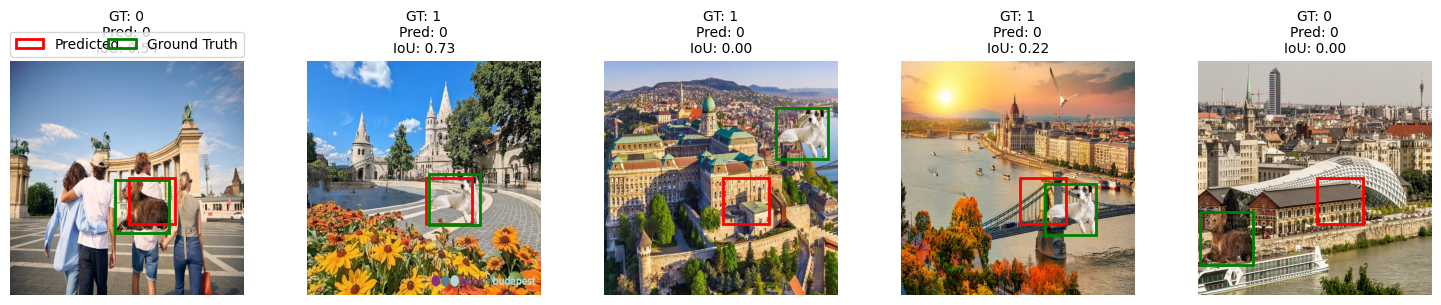

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torch.utils.data import DataLoader

def plot_box_yolo(ax, bbox, color='r', label=None):
    x_center, y_center, width, height = bbox

    # Convert from center coordinates to top-left corner
    x = x_center - width/2
    y = y_center - height/2

    # Create and add the rectangle patch
    rect = patches.Rectangle(
        (x * 640, y * 640),  # Convert normalized coords to pixel coords
        width * 640,         # Convert normalized width to pixels
        height * 640,        # Convert normalized height to pixels
        linewidth=2,
        edgecolor=color,
        facecolor='none',
        label=label
    )
    ax.add_patch(rect)

def plot_box_rect(ax, bbox, color='r', label=None):
    x, y, width, height = bbox

    # Create and add the rectangle patch
    rect = patches.Rectangle(
        (x * 640, y * 640),  # Convert normalized coords to pixel coords
        width * 640,         # Convert normalized width to pixels
        height * 640,        # Convert normalized height to pixels
        linewidth=2,
        edgecolor=color,
        facecolor='none',
        label=label
    )
    ax.add_patch(rect)

def visualize_predictions(model, test_dataset, num_samples=5, title_fontsize=10, axis_fontsize=8):
    # Set model to evaluation mode
    model.eval()

    # Get test dataset loader
    test_loader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

    # Get a batch of samples from the test dataset
    images, labels, bbox_targets = next(iter(test_loader))

    # Print shapes for debugging
    print(f"Image batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Bounding box targets shape: {bbox_targets.shape}")

    # Move images to device
    device = next(model.parameters()).device
    images = images.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        class_probs, bbox_preds = model(images)

    # Convert predicted class probabilities to class labels
    _, predicted_labels = torch.max(class_probs, 1)

    # Create figure
    fig = plt.figure(figsize=(3*num_samples, 3))

    # Plot the images with their ground truth and predicted labels
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)

        # Display the image
        img = images[i].cpu()
        img = img.permute(1, 2, 0)  # Convert from CHW to HWC

        # Normalize image
        if img.max() > 1.0:
            img = img / 255.0

        plt.imshow(img)

        # Get predicted and target bounding boxes
        pred_bbox = bbox_preds[i].cpu()  # [x, y, width, height]
        target_bbox = bbox_targets[i].squeeze(0).cpu()  # YOLO format

        # Plot boxes
        plot_box_rect(ax, pred_bbox, color='r', label='Predicted')  # Rectangle format
        plot_box_yolo(ax, target_bbox, color='g', label='Ground Truth')  # YOLO format

        if i == 0:
            ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                     mode="expand", borderaxespad=0, ncol=2)

        # Convert prediction to YOLO format for IoU calculation
        pred_bbox_yolo = rect_to_yolo(pred_bbox)
        iou = calculate_iou_yolo(pred_bbox_yolo, target_bbox)

        plt.title(f'GT: {labels[i]}\nPred: {predicted_labels[i]}\nIoU: {iou:.2f}',
                 fontsize=title_fontsize)
        plt.axis('off')
        plt.tick_params(axis='both', which='both', labelsize=axis_fontsize)

    plt.tight_layout()
    return fig

def rect_to_yolo(box):
    """
    Convert from [x, y, width, height] to YOLO [x_center, y_center, width, height]
    """
    x, y, width, height = box
    x_center = x + width/2
    y_center = y + height/2
    return torch.tensor([x_center, y_center, width, height])

def calculate_iou_yolo(box1, box2):
    # Convert from [x_center, y_center, width, height] to [x1, y1, x2, y2]
    box1_x1 = box1[0] - box1[2]/2
    box1_y1 = box1[1] - box1[3]/2
    box1_x2 = box1[0] + box1[2]/2
    box1_y2 = box1[1] + box1[3]/2

    box2_x1 = box2[0] - box2[2]/2
    box2_y1 = box2[1] - box2[3]/2
    box2_x2 = box2[0] + box2[2]/2
    box2_y2 = box2[1] + box2[3]/2

    # Calculate intersection
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union = box1_area + box2_area - intersection

    return float(intersection / (union + 1e-6))

fig = visualize_predictions(model, test_dataset)
plt.show()

#Creating yaml file for dataset

In [ ]:
import yaml

def create_dataset_yaml(train_path, val_path, class_names, output_yaml_path):
    data = {
        'train': train_path,
        'val': val_path,
        'nc': len(class_names),
        'names': class_names
    }

    with open(output_yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"data.yaml created and saved to {output_yaml_path}")

train_dir = '/content/drive/MyDrive/DND/data/train/images'
val_dir = '/content/drive/MyDrive/DND/data/val/images'
classes = ['bear', 'dog', 'plant']

output_path = '/content/drive/MyDrive/DND/data/data.yaml'

create_dataset_yaml(train_dir, val_dir, classes, output_path)


data.yaml created and saved to /content/drive/MyDrive/DND/data/data.yaml


### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [ ]:
 # pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.5/877.5 kB 40.2 MB/s eta 0:00:00


### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [ ]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8n.yaml')
fine_tuning_yolo_model = yolo_model.train(data='/content/drive/MyDrive/DND/data/data.yaml', epochs=10, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/DND/data/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hoceinimohammedelamine (hoceinimohammedelamine-e-tv-s-lor-nd-university). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/drive/MyDrive/DND/data/train/labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/DND/data/val/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       2.14      4.308      3.277          8        640: 100%|██████████| 313/313 [16:52<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:14<00:00,  2.33s/it]

                   all       1000       1000      0.828      0.721       0.79      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.063      1.412      1.748          7        640: 100%|██████████| 313/313 [15:24<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:10<00:00,  2.19s/it]

                   all       1000       1000      0.999          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.6803      0.679      1.291          8        640: 100%|██████████| 313/313 [16:01<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:12<00:00,  2.26s/it]

                   all       1000       1000      0.989      0.998      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.5269     0.5048      1.132          7        640: 100%|██████████| 313/313 [16:06<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:13<00:00,  2.31s/it]

                   all       1000       1000      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.4135     0.4007      1.022          8        640: 100%|██████████| 313/313 [15:45<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:14<00:00,  2.34s/it]

                   all       1000       1000          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.3615     0.3456     0.9781          8        640: 100%|██████████| 313/313 [15:38<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:15<00:00,  2.37s/it]

                   all       1000       1000          1          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.3176     0.3105     0.9397          8        640: 100%|██████████| 313/313 [15:42<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:13<00:00,  2.31s/it]

                   all       1000       1000          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.2843     0.2767     0.9149          8        640: 100%|██████████| 313/313 [15:24<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:17<00:00,  2.43s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      0.256     0.2513     0.8948          8        640: 100%|██████████| 313/313 [15:29<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:13<00:00,  2.29s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.2274     0.2269     0.8771          8        640: 100%|██████████| 313/313 [16:03<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:08<00:00,  2.16s/it]

                   all       1000       1000          1          1      0.995      0.995



10 epochs completed in 2.849 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [01:03<00:00,  1.97s/it]


                   all       1000       1000          1          1      0.995      0.995
                  bear        330        330          1          1      0.995      0.995
                   dog        343        343          1          1      0.995      0.995
                 plant        327        327          1          1      0.995      0.995
Speed: 0.6ms preprocess, 48.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train3


lr/pg0,▃▆█▇▆▅▄▃▂▁
lr/pg1,▃▆█▇▆▅▄▃▂▁
lr/pg2,▃▆█▇▆▅▄▃▂▁
metrics/mAP50(B),▁█████████
metrics/mAP50-95(B),▁▇▇███████
metrics/precision(B),▁█████████
metrics/recall(B),▁█████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▃▂▂▁▁▁▁▁


# Save the fine-tuned model in .pt format

In [ ]:
# Save the fine-tuned model in .pt format
torch.save(yolo_model, '/content/drive/MyDrive/DND/data/finetuned_yolo_model_full.pt')

### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [ ]:
# load the model
custom_model = torch.load('/content/drive/MyDrive/DND/data/custom_model_full.pt', map_location=torch.device('cpu'))
# Load the entire YOLO model directly
#finetunedYOLO = torch.load('/content/drive/MyDrive/DND/data/finetuned_yolo_model_full.pt')

<ipython-input-7-1831b5dcb981>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model = torch.load('/content/drive/MyDrive/DND/data/custom_model_full.pt', map_locatio

In [ ]:
precisionCustom, recallCustom, mAPCustom = evaluate_test_set(model, test_loader, device)
print(f"Precision Custom: {precisionCustom:.4f}")
print(f"Recall Custom: {recallCustom:.4f}")
print(f"Mean Average Precision (mAP) Custom: {mAPCustom:.4f}")

Precision Custom: 0.1183
Recall Custom: 0.3333
Mean Average Precision (mAP) Custom: 0.3333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

precisionYOLO, recallYOLO, mAPYOLO = evaluate_test_set(finetunedYOLO, test_loader, device)
print(f"Precision YOLO: {precisionYOLO:.4f}")
print(f"Recall YOLO: {recallYOLO:.4f}")
print(f"Mean Average Precision (mAP) YOLO: {mAPYOLO:.4f}")



New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to runs/detect/train5/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.291      5.359      4.248         19        640: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.269      5.588      4.371         34        640: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 1 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 1 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 100. Steps must be monotonically increasing, so this d

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      3.199      5.263      4.395         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G       3.64      5.516      4.261         29        640: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      3.064      5.585      4.527         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 3 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 3 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 100. Steps must be monotonically increasing, so this d

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      3.629      5.633      4.246         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       3.04      5.512      4.242         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      3.035      5.505      4.267         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 7 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 100. Steps must be monotonically increasing, so 

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      3.428      5.371      4.316         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      3.083      5.587      4.436         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G       3.38      5.613      4.223         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      3.355      5.344       4.24         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      3.136      5.776      4.295         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 10 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 11 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 11 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 11 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 12 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https:/

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      3.169      5.464      4.265         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      3.647      5.589      4.431         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      3.337      5.577       4.22         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.756      5.699      4.312         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 16 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 16 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 16 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 17 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 17 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      3.197      5.467       4.35         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      3.126       5.52      4.264         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G       3.58       5.42      4.286         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      3.251      5.439      4.182         53        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      3.203      5.686      4.337         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 21 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 21 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 21 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 22 that is less than the current step 100. Steps must be monotonically increasing,

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      3.526      5.634      4.271         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G       3.14      5.441       4.27         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      3.701      5.564      4.343         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      2.972      5.416      4.328         24        640: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      3.134      5.549       4.27         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all          4         17          0          0          0          0



wandb: WARNING Tried to log to step 26 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 27 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 27 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 27 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 28 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https:


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      3.091      5.727      4.344         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      2.811      5.484      4.254         44        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      3.142      5.449      4.271         21        640: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      3.525      5.699      4.261         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      3.135      5.662      4.265         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          4         17          0          0          0          0



wandb: WARNING Tried to log to step 31 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 32 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 32 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 32 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 33 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https:


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      3.356       5.47      4.298         26        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      2.827      5.426      4.313         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      3.333      5.614      4.204         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G       2.98      5.394      4.243         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      3.491      5.458      4.258         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 36 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 37 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 37 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 37 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 38 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      3.178      5.481      4.259         21        640: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      2.968      5.423      4.252         46        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      2.982      5.469      4.278         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      2.846      5.477      4.254         41        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 42 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 42 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 42 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 43 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 43 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      3.059      5.524      4.193         44        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      2.959      5.567      4.272         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      3.333       5.36      4.244         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       3.28      5.601      4.277         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 47 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 47 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 47 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 48 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 48 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      3.417      5.645      4.236         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      2.987      5.526      4.226         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      2.817       5.65       4.28         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      3.671       5.47      4.375         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 52 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 52 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 52 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 53 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 53 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      3.258      5.394      4.372         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      3.288       5.35      4.251         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      3.554       5.54      4.383         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      3.281       5.49      4.257         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      3.103      5.436      4.275         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 57 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 57 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 57 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 58 that is less than the current step 100. Steps must be monotonically increasing,

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      3.152       5.33       4.27         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      3.234      5.249      4.483         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      3.472      5.617      4.332         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      2.917      5.338      4.211         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      3.121      5.447      4.211         43        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 62 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 63 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 63 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 63 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 64 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      2.771      5.473      4.292         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      3.405      5.307       4.32         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      3.411      5.117       4.31         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      3.055      5.494      4.232         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 68 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 68 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 68 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 69 that is less than the current step 100. Steps must be monotonically increasing,

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      3.267      5.338      4.231         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      3.359      5.503      4.252         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G       2.81      5.251      4.267         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      3.102      5.415      4.219         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G       3.71      5.134      4.354         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 72 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 73 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 73 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 73 that is less than the current step 100. Steps must be monotonically increasing,

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      3.017        5.3      4.283         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      3.112      5.396      4.328         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      3.542      5.288      4.229         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      2.859      5.244      4.232         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      3.106      5.282      4.231         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 77 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 78 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 78 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 78 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 79 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G       3.77      5.292      4.281         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      3.512      5.352      4.189         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      3.783      5.538      4.261         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      3.084      5.082      4.244         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 83 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 83 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 83 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 84 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 84 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      3.332      5.365      4.317         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      3.475      5.446      4.284         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      2.632      5.496      4.232         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G       2.62      5.474       4.36         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 88 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 88 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 88 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 89 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 89 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      2.688      5.552      4.202         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G       3.18      5.449      4.366         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G        2.9      5.583      4.525         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      2.801      5.465      4.279         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 93 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 93 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 93 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 93 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 94 that is less than the current step 100. Steps must be monotonically increasing, so t

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      3.105      5.408      4.285         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      2.946      5.597      4.264         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17          0          0          0          0



100 epochs completed in 0.058 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.5MB

Validating runs/detect/train5/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          4         17          0          0          0          0


Speed: 0.6ms preprocess, 57.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train5


wandb: WARNING Tried to log to step 98 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 98 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 98 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 99 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 99 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https:/

AttributeError: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    